In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

# DATA

In [2]:
data = {}

data['N'] = 4 #количество подпроцессов
data['D'] = 19 #крайний срок выполнения всех подпроцессов
data['task'] = [] 
data['time'] = []
data['r'] =[np.random.randint(1, 5) for i in range(data['N'])]  #количество сотрудников, необходимых для выполнения подпроцессаi,
data['R'] = 20 # общее количество сотрудников
data['s'] = [np.random.randint(1,10) for i in range(data['N'])]  #продолжительность подпроцесса i
data['Q'] =[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]] #1 если подпроцесс i выполнена после подпроцесс j; 0 иначе; 

for i in range(1, data['N'] + 1):
    data['task'].append(i)

for i in range(1, data['D'] + 1):
    data['time'].append(i)


In [3]:
data

{'N': 4,
 'D': 19,
 'task': [1, 2, 3, 4],
 'time': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'r': [1, 4, 1, 2],
 'R': 20,
 's': [9, 2, 8, 8],
 'Q': [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]}

# Proposed solution

In [4]:
var = {}

var['h'] = [1, 3, 5, 7] #время начала подпроцесса i;
var['x'] = []  #1 если подпроцесс i выполняется в момент времени t; 0 иначе;
var['tmax'] = 0 #общая продолжительность процесса по времени.;

In [5]:
'''
Функция x_filling позволяет нам заполнить 
матрицу x размера (N, D) из вектора h размера N, 
а входные данные data
'''
def x_filling (data, var):
    for i in range(data['N']):
        L = []
        a = var['h'][i]
        b = data['s'][i]
        for j in range(data['D']):
            if j >= a - 1 and j <= a + b - 2:
                L.append(1)
            else:
                L.append(0)
        var['x'].append(L)
    return var['x']

'''
Функция tmax_filling позволяет нам вычислить значение tmax
из вектора h размера N, а входные данные data
'''
def tmax_filling(data, var):
    tmax = 0
    for i in range(data['N']):
        if (var['h'][i]+data['s'][i]) > tmax:
            tmax = var['h'][i]+data['s'][i] - 1
    return tmax

In [6]:
var['x'] = x_filling (data, var)
var['tmax'] = tmax_filling (data, var)

In [7]:
var

{'h': [1, 3, 5, 7],
 'x': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]],
 'tmax': 14}

# MILP Model

In [8]:
'''
 функция, которая возвращает True, если все ограничения моделя  
 соблюдены (если введенное решение выполнимо), и False в противном случае.
'''

def Model(data, var):
    M = 2500
    flag = True
    #(1) Весь процесс должен быть завершен до крайнего срока
    if var['tmax'] <= data['D']:
        flag = True
    else:
        return False
    
    #(2) Общая продолжительность процесса должна быть больше или равна дате окончания подпроцесса i.
    for i in range(data['N']):
        if var['tmax'] >= var['h'][i] + data['s'][i] - 1:
            flag = True
        else:
            return False
    
    #(3) Если подпроцесс j предшествует подпроцесса i, то подпроцесс i может начаться 
    #только после завершения подпроцесса j.
    for i in range(data['N']):
        for j in range(data['N']):
            if data['Q'][i][j] * var['h'][i] >= data['Q'][i][j] *  (var['h'][j] + data['s'][j]):
                flag = True
            else:
                return False
            
    #(4) Общее время выполнения подпроцесса должно быть равно времени ее завершения.
    for i in range(data['N']):
        if sum(var['x'][i]) == data['s'][i]:
            flag = True
        else:
            return False
        
    #(5) количество сотрудников, занятых в момент t, меньше или равно общему количеству сотрудников.
    for t in range(data['D']):
        employee = 0
        for i in range(data['N']):
            employee = employee + data['r'][i] * var['x'][i][t]
        if employee <= data['R']:
            flag = True
        else:
            return False
    #(6) (7) общая продолжительность выполнения подпроцесса i должна быть между временем начала и временем окончания.
    for i in range(1, data['N'] + 1):
        for t in range(1, data['D'] + 1):
            if t * var['x'][i -1][t - 1] + (1 - var['x'][i - 1][t - 1]) * M >= var['h'][i - 1]:
                flag = True
            else:
                return False
    
    for i in range(1, data['N'] + 1):
        for t in range(1, data['D'] + 1):
            if t * var['x'][i -1][t - 1] - (1 - var['x'][i - 1][t - 1]) * M <= var['h'][i - 1] + data['s'][i - 1] - 1:
                flag = True
            else:
                return False
        
    return flag
    
    

In [9]:
Model(data, var)

True

# Visualization of the solution

In [10]:
def Visual(data, var):  
    # Declaring a figure "gnt" 
    fig, gnt = plt.subplots(figsize=(15, 15)) 
      
    # Setting Y-axis limits 
    gnt.set_ylim(0, data['N'] + 2) 
      
    # Setting X-axis limits 
    gnt.set_xlim(0, data['D'] + 2) 
      
    # Setting labels for x-axis and y-axis 
    gnt.set_xlabel('time') 
    gnt.set_ylabel('processes') 
    
    # Setting graph attribute 
    gnt.grid(True) 
    
    # Declaring multiple bars  
    for i in range(1,(data['N'])+1):
        gnt.broken_barh([(var['h'][i-1], data['s'][i-1])], (i, 1),
                                                  facecolors =('black'))
    plt.axvline(x = var['tmax'] +1, color = 'green', alpha = 0.5, linestyle = '--', linewidth = 4)
    plt.axvline(x = data['D'] +1, color = 'red', alpha = 0.5, linestyle = '--', linewidth = 4)

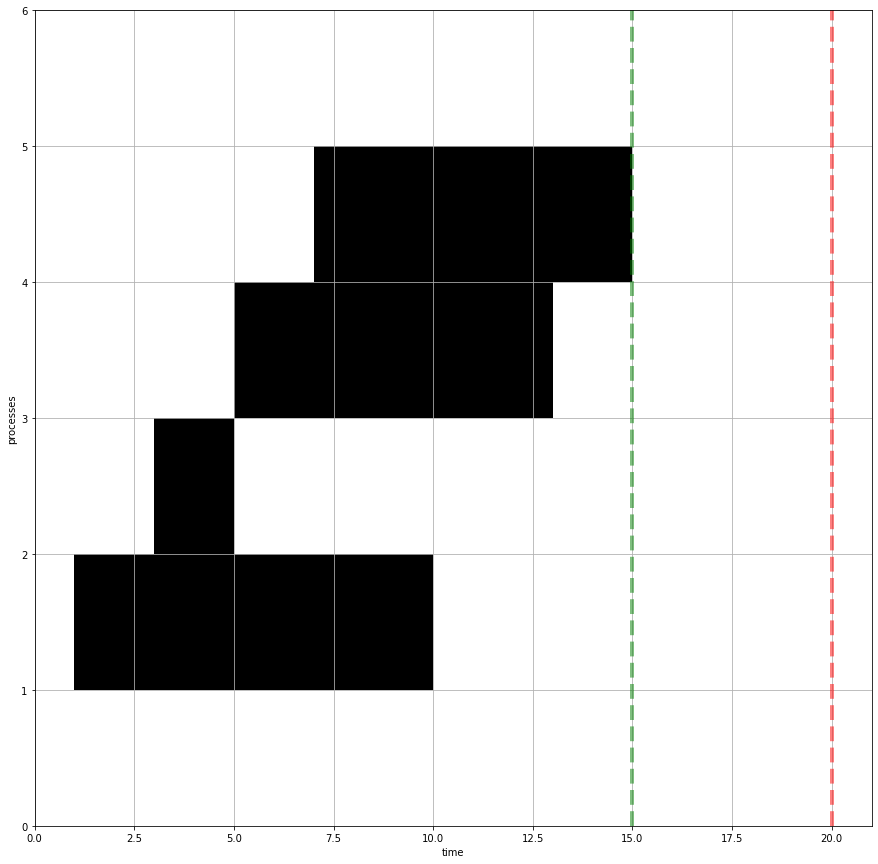

In [11]:
if Model(data, var) == True:
    Visual(data, var)

# Genetic Algorithm

In [12]:
def fitness(h, data):
    newVar = {}
    newVar['h'] = []
    newVar['x'] = []
    newVar['tmax'] = 0
    
    newVar['h'] = h
    newVar['x'] = x_filling (data, newVar)
    newVar['tmax'] = tmax_filling (data, newVar)
    
    ans = Model(data, newVar)
    
    if ans == True:
        return newVar['tmax']
        

population = []
for s in range(1000):
    population.append([np.random.randint(1, 10) for i in range(data['N'])])
    
for i in range(100):
    rankedsolutions = []
    for s in population:
        rankedsolutions.append((fitness(s, data), s))
    rankedsolutions.sort()
    bestsolutions = rankedsolutions[:100]
    
    elements = []
    for s in bestsolutions:
        elements.append(s[1])
    
    newGen=[]
    for _ in range(1000):
        e = rd.choice(elements) 
        newGen.append(e)
    population = newGen

In [13]:
rankedsolutions[0][1]

[1, 2, 1, 1]

In [14]:
genVar = {}
genVar['h'] = []
genVar['x'] = []
genVar['tmax'] = 0
    
genVar['h'] = rankedsolutions[0][1]
genVar['x'] = x_filling (data, genVar)
genVar['tmax'] = tmax_filling (data, genVar)

In [15]:
genVar

{'h': [1, 2, 1, 1],
 'x': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'tmax': 9}

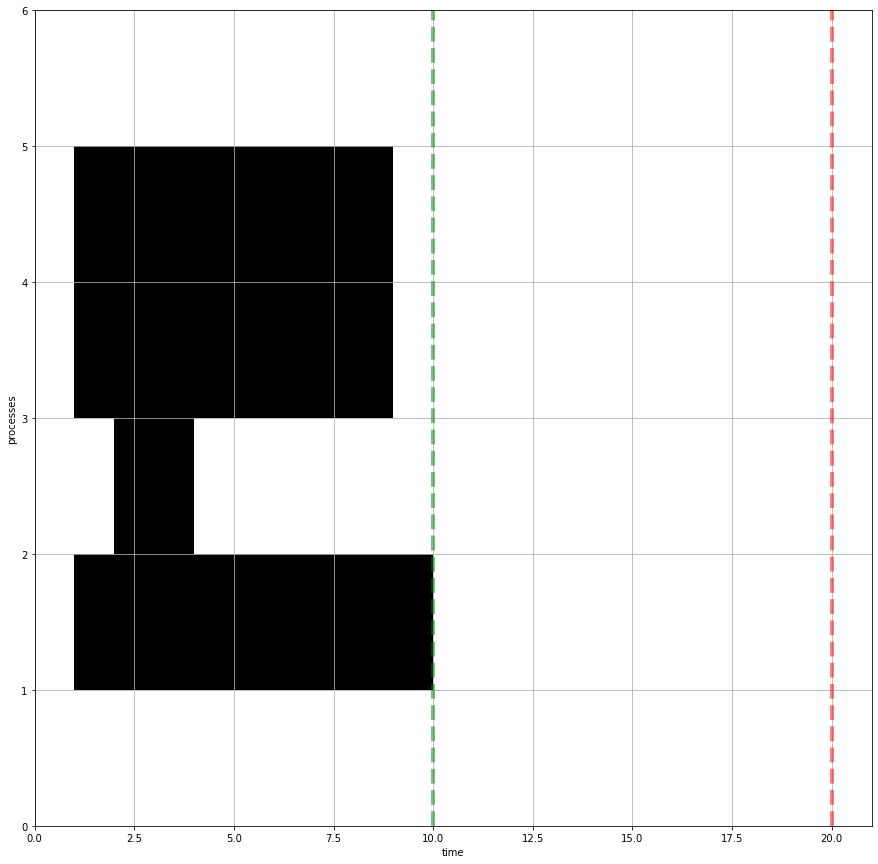

In [16]:
if Model(data, var) == True:
    Visual(data, genVar)